In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from PIL import ImageFont, ImageDraw, Image
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import os

def get_korean_font_path():
    # Jupyter 환경에서 사용할 수 있는 대표적인 한글 폰트 경로
    candidates = [
        "/usr/share/fonts/NanumFont/NanumGothic.ttf",
        "/usr/share/fonts/NanumFont/NanumGothicBold.ttf",
        "/usr/share/fonts/truetype/unfonts-core/UnDotum.ttf",
        "/usr/share/fonts/opentype/noto/NotoSansCJK-Regular.ttc"
    ]
    for path in candidates:
        if os.path.exists(path):
            return path
    return None  # 폰트가 없을 경우

# ---- 전역 Matplotlib 폰트 설정 ----
font_path = get_korean_font_path()
if font_path:
    plt.rcParams['font.family'] = fm.FontProperties(fname=font_path).get_name()
    plt.rcParams['axes.unicode_minus'] = False
else:
    print("⚠️ 한글 폰트를 찾을 수 없습니다. Matplotlib 제목은 깨질 수 있습니다.")

def analyze_blur_grid(image_path, grid_x=5, grid_y=4, threshold=10000.0):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        raise ValueError("이미지를 불러올 수 없습니다.")

    height, width = image.shape
    seg_w = width // grid_x
    seg_h = height // grid_y

    print(f"이미지 크기: {width}x{height}")
    print(f"{grid_x}x{grid_y} 격자로 나눠 분석합니다.\n")

    cx = width // 2
    cy = height // 2
    radius = int(np.sqrt(0.8 * width * height / np.pi))

    sharp_count = 0
    central_segment_count = 0
    scores = {}

    for i in range(grid_y):
        for j in range(grid_x):
            y_start = i * seg_h
            y_end = (i + 1) * seg_h if i < grid_y - 1 else height
            x_start = j * seg_w
            x_end = (j + 1) * seg_w if j < grid_x - 1 else width

            center_x = (x_start + x_end) // 2
            center_y = (y_start + y_end) // 2
            distance = np.sqrt((center_x - cx)**2 + (center_y - cy)**2)

            if distance <= radius:
                segment = image[y_start:y_end, x_start:x_end]
                laplacian = cv2.Laplacian(segment, cv2.CV_64F)
                variance = laplacian.var()
                scores[(i, j)] = (variance, (x_start, y_start, x_end, y_end))
                status = "OK" if variance >= threshold else "NG"
                if variance >= threshold:
                    sharp_count += 1
                central_segment_count += 1
                print(f"원형 구간 ({i+1},{j+1}): 분산 = {variance:.2f} → {status}")
            else:
                print(f"외곽 구간 ({i+1},{j+1}): 평가 제외")

    if central_segment_count == 0:
        print("⚠️ 원형 영역에 해당하는 구간이 없습니다.")
        return

    sharp_ratio = sharp_count / central_segment_count
    print(f"\n원형 영역 선명 구간 비율: {sharp_ratio:.2%}")

    message = "✅ OK: 중심 원형 영역이 충분히 선명합니다!" if sharp_ratio >= 0.8 else "⚠️ 흐림: 중심 영역 선명도 부족"
    show_result_with_grid_scores(image_path, message, scores, threshold, cx, cy, radius, sharp_ratio)

    return scores, threshold

def show_result_with_grid_scores(image_path, message, scores, threshold, cx, cy, radius, sharp_ratio):
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError("이미지를 불러올 수 없습니다.")

    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_pil = Image.fromarray(img_rgb)
    draw = ImageDraw.Draw(img_pil)

    font_path = get_korean_font_path()
    if font_path:
        font = ImageFont.truetype(font_path, 40)
        msg_color = (0, 255, 0) if sharp_ratio >= 0.8 else (255, 0, 0)
        draw.text((30, 50), message, font=font, fill=msg_color)
    else:
        print("⚠️ 한글 폰트를 찾을 수 없습니다. 메시지를 출력하지 않습니다.")

    img = cv2.cvtColor(np.array(img_pil), cv2.COLOR_RGB2BGR)
    font_cv = cv2.FONT_HERSHEY_SIMPLEX

    for (i, j), (variance, (x_start, y_start, x_end, y_end)) in scores.items():
        color = (0, 255, 0) if variance >= threshold else (0, 0, 255)
        label = f"{variance:.0f}"
        cv2.rectangle(img, (x_start, y_start), (x_end, y_end), color, 2)
        text_x = x_start + 5
        text_y = y_start + 30
        cv2.putText(img, label, (text_x, text_y), font_cv, 1.0, color, 2, cv2.LINE_AA)

    cv2.circle(img, (cx, cy), radius, (255, 0, 0), 2)

    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(10, 8))
    plt.imshow(img_rgb)
    plt.title("포커스 검사결과", fontsize=20, fontweight='bold')  # 이제 한글 깨짐 없음
    plt.axis("off")
    plt.show()

# 실행 및 머신러닝 평가
scores, threshold = analyze_blur_grid("FOCUS2.jpg", grid_x=16, grid_y=9, threshold=10000.0)

X = []
y = []

for (i, j), (variance, _) in scores.items():
    X.append([variance])
    y.append(1 if variance >= threshold else 0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
model = SVC()
model.fit(X_train, y_train)
pred = model.predict(X_test)
print("정확도:", accuracy_score(y_test, pred))

이미지 크기: 1920x1080
16x9 격자로 나눠 분석합니다.

외곽 구간 (1,1): 평가 제외
외곽 구간 (1,2): 평가 제외
외곽 구간 (1,3): 평가 제외
원형 구간 (1,4): 분산 = 21589.15 → OK
원형 구간 (1,5): 분산 = 17291.53 → OK
원형 구간 (1,6): 분산 = 14612.65 → OK
원형 구간 (1,7): 분산 = 13471.22 → OK
원형 구간 (1,8): 분산 = 12917.54 → OK
원형 구간 (1,9): 분산 = 10289.26 → OK
원형 구간 (1,10): 분산 = 13986.80 → OK
원형 구간 (1,11): 분산 = 11335.81 → OK
원형 구간 (1,12): 분산 = 7353.76 → NG
원형 구간 (1,13): 분산 = 6075.57 → NG
외곽 구간 (1,14): 평가 제외
외곽 구간 (1,15): 평가 제외
외곽 구간 (1,16): 평가 제외
외곽 구간 (2,1): 평가 제외
외곽 구간 (2,2): 평가 제외
외곽 구간 (2,3): 평가 제외
원형 구간 (2,4): 분산 = 17224.74 → OK
원형 구간 (2,5): 분산 = 14758.80 → OK
원형 구간 (2,6): 분산 = 18985.24 → OK
원형 구간 (2,7): 분산 = 17302.11 → OK
원형 구간 (2,8): 분산 = 17595.20 → OK
원형 구간 (2,9): 분산 = 14700.79 → OK
원형 구간 (2,10): 분산 = 21977.63 → OK
원형 구간 (2,11): 분산 = 18712.82 → OK
원형 구간 (2,12): 분산 = 13384.91 → OK
원형 구간 (2,13): 분산 = 8404.84 → NG
외곽 구간 (2,14): 평가 제외
외곽 구간 (2,15): 평가 제외
외곽 구간 (2,16): 평가 제외
외곽 구간 (3,1): 평가 제외
외곽 구간 (3,2): 평가 제외
원형 구간 (3,3): 분산 = 17611.28 → OK
원형 구간 (3,4): 

정확도: 0.95


In [5]:
def analyze_quadrant_bias(image_path, threshold=10000.0):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        raise ValueError("이미지를 불러올 수 없습니다.")

    h, w = image.shape
    mid_h, mid_w = h // 2, w // 2

    quadrants = {
        "좌상": image[0:mid_h, 0:mid_w],
        "우상": image[0:mid_h, mid_w:w],
        "좌하": image[mid_h:h, 0:mid_w],
        "우하": image[mid_h:h, mid_w:w],
    }

    results = {}
    for name, seg in quadrants.items():
        var = cv2.Laplacian(seg, cv2.CV_64F).var()
        results[name] = var
        print(f"{name} 분산 = {var:.2f}")

    # 좌우/상하 평균 비교
    left_mean = (results["좌상"] + results["좌하"]) / 2
    right_mean = (results["우상"] + results["우하"]) / 2
    top_mean = (results["좌상"] + results["우상"]) / 2
    bottom_mean = (results["좌하"] + results["우하"]) / 2

    print(f"\n좌우 편심: 왼쪽={left_mean:.2f}, 오른쪽={right_mean:.2f}")
    print(f"상하 편심: 위쪽={top_mean:.2f}, 아래쪽={bottom_mean:.2f}")

    return results
quadrant_scores = analyze_quadrant_bias("FOCUS2.jpg")


좌상 분산 = 17277.98
우상 분산 = 11904.93
좌하 분산 = 11662.32
우하 분산 = 10617.43

좌우 편심: 왼쪽=14470.15, 오른쪽=11261.18
상하 편심: 위쪽=14591.45, 아래쪽=11139.88


In [6]:
def analyze_quadrant_bias(image_path, threshold=10000.0):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        raise ValueError("이미지를 불러올 수 없습니다.")

    h, w = image.shape
    mid_h, mid_w = h // 2, w // 2

    quadrants = {
        "좌상": image[0:mid_h, 0:mid_w],
        "우상": image[0:mid_h, mid_w:w],
        "좌하": image[mid_h:h, 0:mid_w],
        "우하": image[mid_h:h, mid_w:w],
    }

    results = {}
    for name, seg in quadrants.items():
        var = cv2.Laplacian(seg, cv2.CV_64F).var()
        results[name] = var
        print(f"{name} 분산 = {var:.2f}")

    # 좌우/상하 평균 비교
    left_mean = (results["좌상"] + results["좌하"]) / 2
    right_mean = (results["우상"] + results["우하"]) / 2
    top_mean = (results["좌상"] + results["우상"]) / 2
    bottom_mean = (results["좌하"] + results["우하"]) / 2

    print(f"\n좌우 편심: 왼쪽={left_mean:.2f}, 오른쪽={right_mean:.2f}")
    print(f"상하 편심: 위쪽={top_mean:.2f}, 아래쪽={bottom_mean:.2f}")

    # ---- 편심 판정 추가 ----
    if abs(left_mean - right_mean) >= 1000:
        if left_mean > right_mean:
            print("➡️ 왼쪽이 편심입니다.")
        else:
            print("➡️ 오른쪽이 편심입니다.")
    else:
        print("좌우 편심 없음")

    if abs(top_mean - bottom_mean) >= 1000:
        if top_mean > bottom_mean:
            print("⬆️ 위쪽이 편심입니다.")
        else:
            print("⬇️ 아래쪽이 편심입니다.")
    else:
        print("상하 편심 없음")

    return results
quadrant_scores = analyze_quadrant_bias("FOCUS2.jpg")


좌상 분산 = 17277.98
우상 분산 = 11904.93
좌하 분산 = 11662.32
우하 분산 = 10617.43

좌우 편심: 왼쪽=14470.15, 오른쪽=11261.18
상하 편심: 위쪽=14591.45, 아래쪽=11139.88
➡️ 왼쪽이 편심입니다.
⬆️ 위쪽이 편심입니다.


In [7]:
def analyze_blur_grid(image_path, grid_x=5, grid_y=4, threshold=10000.0):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        raise ValueError("이미지를 불러올 수 없습니다.")

    height, width = image.shape
    seg_w = width // grid_x
    seg_h = height // grid_y

    print(f"이미지 크기: {width}x{height}")
    print(f"{grid_x}x{grid_y} 격자로 나눠 분석합니다.\n")

    cx = width // 2
    cy = height // 2
    radius = int(np.sqrt(0.8 * width * height / np.pi))

    sharp_count = 0
    central_segment_count = 0
    scores = {}

    for i in range(grid_y):
        for j in range(grid_x):
            y_start = i * seg_h
            y_end = (i + 1) * seg_h if i < grid_y - 1 else height
            x_start = j * seg_w
            x_end = (j + 1) * seg_w if j < grid_x - 1 else width

            center_x = (x_start + x_end) // 2
            center_y = (y_start + y_end) // 2
            distance = np.sqrt((center_x - cx)**2 + (center_y - cy)**2)

            if distance <= radius:
                segment = image[y_start:y_end, x_start:x_end]
                laplacian = cv2.Laplacian(segment, cv2.CV_64F)
                variance = laplacian.var()
                scores[(i, j)] = (variance, (x_start, y_start, x_end, y_end))
                status = "OK" if variance >= threshold else "NG"
                if variance >= threshold:
                    sharp_count += 1
                central_segment_count += 1
                print(f"원형 구간 ({i+1},{j+1}): 분산 = {variance:.2f} → {status}")
            else:
                print(f"외곽 구간 ({i+1},{j+1}): 평가 제외")

    # ---- 항상 결과 출력 ----
    if central_segment_count == 0:
        print("⚠️ 원형 영역에 해당하는 구간이 없습니다.")
        sharp_ratio = 0
        message = "⚠️ 원형 영역 없음"
    else:
        sharp_ratio = sharp_count / central_segment_count
        print(f"\n원형 영역 선명 구간 비율: {sharp_ratio:.2%}")
        message = "✅ OK: 중심 원형 영역이 충분히 선명합니다!" if sharp_ratio >= 0.8 else "⚠️ 흐림: 중심 영역 선명도 부족"

    show_result_with_grid_scores(image_path, message, scores, threshold, cx, cy, radius, sharp_ratio)
    return scores, threshold

이미지 크기: 1920x1080
16x9 격자로 나눠 분석합니다.

외곽 구간 (1,1): 평가 제외
외곽 구간 (1,2): 평가 제외
외곽 구간 (1,3): 평가 제외
원형 구간 (1,4): 분산 = 21589.15 → OK
원형 구간 (1,5): 분산 = 17291.53 → OK
원형 구간 (1,6): 분산 = 14612.65 → OK
원형 구간 (1,7): 분산 = 13471.22 → OK
원형 구간 (1,8): 분산 = 12917.54 → NG
원형 구간 (1,9): 분산 = 10289.26 → NG
원형 구간 (1,10): 분산 = 13986.80 → OK
원형 구간 (1,11): 분산 = 11335.81 → NG
원형 구간 (1,12): 분산 = 7353.76 → NG
원형 구간 (1,13): 분산 = 6075.57 → NG
외곽 구간 (1,14): 평가 제외
외곽 구간 (1,15): 평가 제외
외곽 구간 (1,16): 평가 제외
외곽 구간 (2,1): 평가 제외
외곽 구간 (2,2): 평가 제외
외곽 구간 (2,3): 평가 제외
원형 구간 (2,4): 분산 = 17224.74 → OK
원형 구간 (2,5): 분산 = 14758.80 → OK
원형 구간 (2,6): 분산 = 18985.24 → OK
원형 구간 (2,7): 분산 = 17302.11 → OK
원형 구간 (2,8): 분산 = 17595.20 → OK
원형 구간 (2,9): 분산 = 14700.79 → OK
원형 구간 (2,10): 분산 = 21977.63 → OK
원형 구간 (2,11): 분산 = 18712.82 → OK
원형 구간 (2,12): 분산 = 13384.91 → OK
원형 구간 (2,13): 분산 = 8404.84 → NG
외곽 구간 (2,14): 평가 제외
외곽 구간 (2,15): 평가 제외
외곽 구간 (2,16): 평가 제외
외곽 구간 (3,1): 평가 제외
외곽 구간 (3,2): 평가 제외
원형 구간 (3,3): 분산 = 17611.28 → OK
원형 구간 (3,4): 

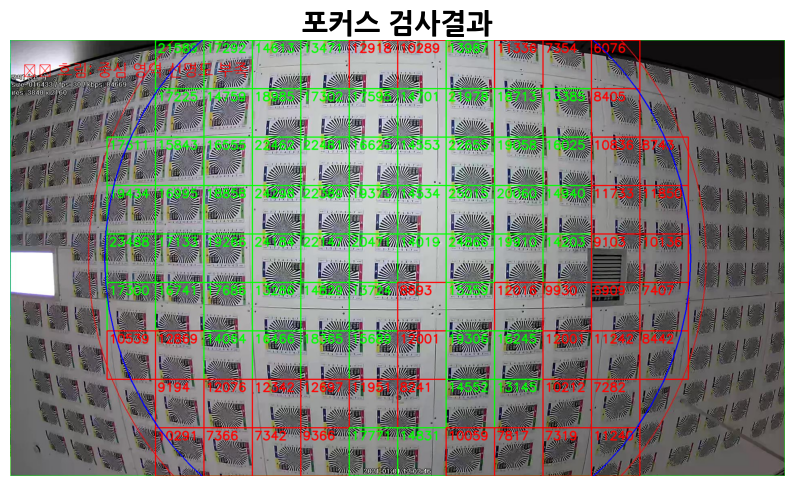

정확도: 0.95


In [9]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from PIL import ImageFont, ImageDraw, Image
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import os

def get_korean_font_path():
    # Jupyter 환경에서 사용할 수 있는 대표적인 한글 폰트 경로
    candidates = [
        "/usr/share/fonts/NanumFont/NanumGothic.ttf",
        "/usr/share/fonts/NanumFont/NanumGothicBold.ttf",
        "/usr/share/fonts/truetype/unfonts-core/UnDotum.ttf",
        "/usr/share/fonts/opentype/noto/NotoSansCJK-Regular.ttc"
    ]
    for path in candidates:
        if os.path.exists(path):
            return path
    return None  # 폰트가 없을 경우

# ---- 전역 Matplotlib 폰트 설정 ----
font_path = get_korean_font_path()
if font_path:
    plt.rcParams['font.family'] = fm.FontProperties(fname=font_path).get_name()
    plt.rcParams['axes.unicode_minus'] = False
else:
    print("⚠️ 한글 폰트를 찾을 수 없습니다. Matplotlib 제목은 깨질 수 있습니다.")

def analyze_blur_grid(image_path, grid_x=5, grid_y=4, threshold=10000.0):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        raise ValueError("이미지를 불러올 수 없습니다.")

    height, width = image.shape
    seg_w = width // grid_x
    seg_h = height // grid_y

    print(f"이미지 크기: {width}x{height}")
    print(f"{grid_x}x{grid_y} 격자로 나눠 분석합니다.\n")

    cx = width // 2
    cy = height // 2
    radius = int(np.sqrt(0.8 * width * height / np.pi))

    sharp_count = 0
    central_segment_count = 0
    scores = {}

    for i in range(grid_y):
        for j in range(grid_x):
            y_start = i * seg_h
            y_end = (i + 1) * seg_h if i < grid_y - 1 else height
            x_start = j * seg_w
            x_end = (j + 1) * seg_w if j < grid_x - 1 else width

            center_x = (x_start + x_end) // 2
            center_y = (y_start + y_end) // 2
            distance = np.sqrt((center_x - cx)**2 + (center_y - cy)**2)

            if distance <= radius:
                segment = image[y_start:y_end, x_start:x_end]
                laplacian = cv2.Laplacian(segment, cv2.CV_64F)
                variance = laplacian.var()
                scores[(i, j)] = (variance, (x_start, y_start, x_end, y_end))
                status = "OK" if variance >= threshold else "NG"
                if variance >= threshold:
                    sharp_count += 1
                central_segment_count += 1
                print(f"원형 구간 ({i+1},{j+1}): 분산 = {variance:.2f} → {status}")
            else:
                print(f"외곽 구간 ({i+1},{j+1}): 평가 제외")

    # ---- 항상 결과 출력 ----
    if central_segment_count == 0:
        print("⚠️ 원형 영역에 해당하는 구간이 없습니다.")
        sharp_ratio = 0
        message = "⚠️ 원형 영역 없음"
    else:
        sharp_ratio = sharp_count / central_segment_count
        print(f"\n원형 영역 선명 구간 비율: {sharp_ratio:.2%}")
        message = "✅ OK: 중심 원형 영역이 충분히 선명합니다!" if sharp_ratio >= 0.8 else "⚠️ 흐림: 중심 영역 선명도 부족"

    show_result_with_grid_scores(image_path, message, scores, threshold, cx, cy, radius, sharp_ratio)
    return scores, threshold

def show_result_with_grid_scores(image_path, message, scores, threshold, cx, cy, radius, sharp_ratio):
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError("이미지를 불러올 수 없습니다.")

    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_pil = Image.fromarray(img_rgb)
    draw = ImageDraw.Draw(img_pil)

    font_path = get_korean_font_path()
    if font_path:
        font = ImageFont.truetype(font_path, 40)
        msg_color = (0, 255, 0) if sharp_ratio >= 0.8 else (255, 0, 0)
        draw.text((30, 50), message, font=font, fill=msg_color)
    else:
        print("⚠️ 한글 폰트를 찾을 수 없습니다. 메시지를 출력하지 않습니다.")

    img = cv2.cvtColor(np.array(img_pil), cv2.COLOR_RGB2BGR)
    font_cv = cv2.FONT_HERSHEY_SIMPLEX

    for (i, j), (variance, (x_start, y_start, x_end, y_end)) in scores.items():
        color = (0, 255, 0) if variance >= threshold else (0, 0, 255)
        label = f"{variance:.0f}"
        cv2.rectangle(img, (x_start, y_start), (x_end, y_end), color, 2)
        text_x = x_start + 5
        text_y = y_start + 30
        cv2.putText(img, label, (text_x, text_y), font_cv, 1.0, color, 2, cv2.LINE_AA)

    cv2.circle(img, (cx, cy), radius, (255, 0, 0), 2)

    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(10, 8))
    plt.imshow(img_rgb)
    plt.title("포커스 검사결과", fontsize=20, fontweight='bold')
    plt.axis("off")
    plt.show()

# 실행 및 머신러닝 평가
scores, threshold = analyze_blur_grid("FOCUS2.jpg", grid_x=16, grid_y=9, threshold=13000.0)

X = []
y = []

for (i, j), (variance, _) in scores.items():
    X.append([variance])
    y.append(1 if variance >= threshold else 0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
model = SVC()
model.fit(X_train, y_train)
pred = model.predict(X_test)
print("정확도:", accuracy_score(y_test, pred))

이미지 크기: 1920x1080
16x9 격자로 나눠 분석합니다.

외곽 구간 (1,1): 평가 제외
외곽 구간 (1,2): 평가 제외
외곽 구간 (1,3): 평가 제외
원형 구간 (1,4): 분산 = 21589.15 → OK
원형 구간 (1,5): 분산 = 17291.53 → OK
원형 구간 (1,6): 분산 = 14612.65 → OK
원형 구간 (1,7): 분산 = 13471.22 → OK
원형 구간 (1,8): 분산 = 12917.54 → OK
원형 구간 (1,9): 분산 = 10289.26 → OK
원형 구간 (1,10): 분산 = 13986.80 → OK
원형 구간 (1,11): 분산 = 11335.81 → OK
원형 구간 (1,12): 분산 = 7353.76 → OK
원형 구간 (1,13): 분산 = 6075.57 → OK
외곽 구간 (1,14): 평가 제외
외곽 구간 (1,15): 평가 제외
외곽 구간 (1,16): 평가 제외
외곽 구간 (2,1): 평가 제외
외곽 구간 (2,2): 평가 제외
외곽 구간 (2,3): 평가 제외
원형 구간 (2,4): 분산 = 17224.74 → OK
원형 구간 (2,5): 분산 = 14758.80 → OK
원형 구간 (2,6): 분산 = 18985.24 → OK
원형 구간 (2,7): 분산 = 17302.11 → OK
원형 구간 (2,8): 분산 = 17595.20 → OK
원형 구간 (2,9): 분산 = 14700.79 → OK
원형 구간 (2,10): 분산 = 21977.63 → OK
원형 구간 (2,11): 분산 = 18712.82 → OK
원형 구간 (2,12): 분산 = 13384.91 → OK
원형 구간 (2,13): 분산 = 8404.84 → OK
외곽 구간 (2,14): 평가 제외
외곽 구간 (2,15): 평가 제외
외곽 구간 (2,16): 평가 제외
외곽 구간 (3,1): 평가 제외
외곽 구간 (3,2): 평가 제외
원형 구간 (3,3): 분산 = 17611.28 → OK
원형 구간 (3,4): 

/tmp/ipykernel_1081/1634936882.py:110: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_w, text_h = draw.textsize(text, font=font_big)


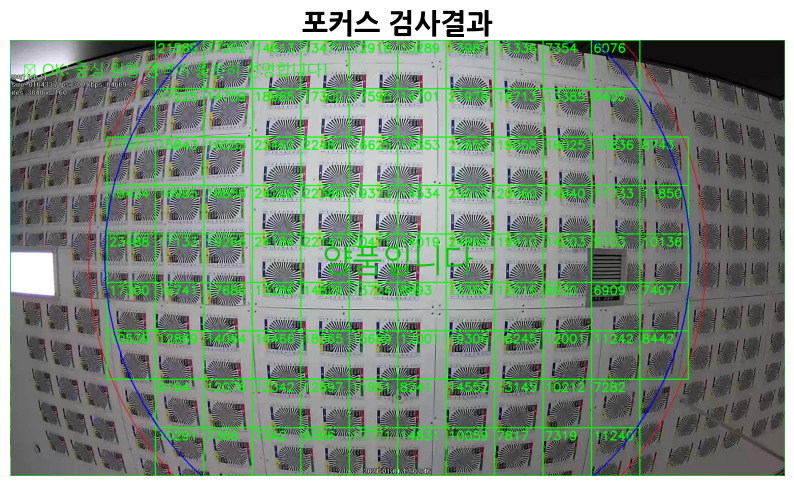

ValueError: The number of classes has to be greater than one; got 1 class

In [11]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from PIL import ImageFont, ImageDraw, Image
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import os

def get_korean_font_path():
    # Jupyter 환경에서 사용할 수 있는 대표적인 한글 폰트 경로
    candidates = [
        "/usr/share/fonts/NanumFont/NanumGothic.ttf",
        "/usr/share/fonts/NanumFont/NanumGothicBold.ttf",
        "/usr/share/fonts/truetype/unfonts-core/UnDotum.ttf",
        "/usr/share/fonts/opentype/noto/NotoSansCJK-Regular.ttc"
    ]
    for path in candidates:
        if os.path.exists(path):
            return path
    return None  # 폰트가 없을 경우

# ---- 전역 Matplotlib 폰트 설정 ----
font_path = get_korean_font_path()
if font_path:
    plt.rcParams['font.family'] = fm.FontProperties(fname=font_path).get_name()
    plt.rcParams['axes.unicode_minus'] = False
else:
    print("⚠️ 한글 폰트를 찾을 수 없습니다. Matplotlib 제목은 깨질 수 있습니다.")

def analyze_blur_grid(image_path, grid_x=5, grid_y=4, threshold=10000.0):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        raise ValueError("이미지를 불러올 수 없습니다.")

    height, width = image.shape
    seg_w = width // grid_x
    seg_h = height // grid_y

    print(f"이미지 크기: {width}x{height}")
    print(f"{grid_x}x{grid_y} 격자로 나눠 분석합니다.\n")

    cx = width // 2
    cy = height // 2
    radius = int(np.sqrt(0.8 * width * height / np.pi))

    sharp_count = 0
    central_segment_count = 0
    scores = {}

    for i in range(grid_y):
        for j in range(grid_x):
            y_start = i * seg_h
            y_end = (i + 1) * seg_h if i < grid_y - 1 else height
            x_start = j * seg_w
            x_end = (j + 1) * seg_w if j < grid_x - 1 else width

            center_x = (x_start + x_end) // 2
            center_y = (y_start + y_end) // 2
            distance = np.sqrt((center_x - cx)**2 + (center_y - cy)**2)

            if distance <= radius:
                segment = image[y_start:y_end, x_start:x_end]
                laplacian = cv2.Laplacian(segment, cv2.CV_64F)
                variance = laplacian.var()
                scores[(i, j)] = (variance, (x_start, y_start, x_end, y_end))
                status = "OK" if variance >= threshold else "NG"
                if variance >= threshold:
                    sharp_count += 1
                central_segment_count += 1
                print(f"원형 구간 ({i+1},{j+1}): 분산 = {variance:.2f} → {status}")
            else:
                print(f"외곽 구간 ({i+1},{j+1}): 평가 제외")

    # ---- 항상 결과 출력 ----
    if central_segment_count == 0:
        print("⚠️ 원형 영역에 해당하는 구간이 없습니다.")
        sharp_ratio = 0
        message = "⚠️ 원형 영역 없음"
    else:
        sharp_ratio = sharp_count / central_segment_count
        print(f"\n원형 영역 선명 구간 비율: {sharp_ratio:.2%}")
        message = "✅ OK: 중심 원형 영역이 충분히 선명합니다!" if sharp_ratio >= 0.8 else "⚠️ 흐림: 중심 영역 선명도 부족"

    show_result_with_grid_scores(image_path, message, scores, threshold, cx, cy, radius, sharp_ratio)
    return scores, threshold

def show_result_with_grid_scores(image_path, message, scores, threshold, cx, cy, radius, sharp_ratio):
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError("이미지를 불러올 수 없습니다.")

    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_pil = Image.fromarray(img_rgb)
    draw = ImageDraw.Draw(img_pil)

    font_path = get_korean_font_path()
    if font_path:
        font = ImageFont.truetype(font_path, 40)
        msg_color = (0, 255, 0) if sharp_ratio >= 0.8 else (255, 0, 0)
        draw.text((30, 50), message, font=font, fill=msg_color)

        # ---- 추가: 양품 표시 ----
        if sharp_ratio >= 0.95:
            center_x = img_pil.width // 2
            center_y = img_pil.height // 2
            font_big = ImageFont.truetype(font_path, 80)  # 크게 표시
            text = "양품입니다"
            text_w, text_h = draw.textsize(text, font=font_big)
            draw.text((center_x - text_w//2, center_y - text_h//2),
                      text, font=font_big, fill=(0, 200, 0))
    else:
        print("⚠️ 한글 폰트를 찾을 수 없습니다. 메시지를 출력하지 않습니다.")

    img = cv2.cvtColor(np.array(img_pil), cv2.COLOR_RGB2BGR)
    font_cv = cv2.FONT_HERSHEY_SIMPLEX

    for (i, j), (variance, (x_start, y_start, x_end, y_end)) in scores.items():
        color = (0, 255, 0) if variance >= threshold else (0, 0, 255)
        label = f"{variance:.0f}"
        cv2.rectangle(img, (x_start, y_start), (x_end, y_end), color, 2)
        text_x = x_start + 5
        text_y = y_start + 30
        cv2.putText(img, label, (text_x, text_y), font_cv, 1.0, color, 2, cv2.LINE_AA)

    cv2.circle(img, (cx, cy), radius, (255, 0, 0), 2)

    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(10, 8))
    plt.imshow(img_rgb)
    plt.title("포커스 검사결과", fontsize=20, fontweight='bold')
    plt.axis("off")
    plt.show()

# 실행 및 머신러닝 평가
scores, threshold = analyze_blur_grid("FOCUS2.jpg", grid_x=16, grid_y=9, threshold=5000.0)

X = []
y = []

for (i, j), (variance, _) in scores.items():
    X.append([variance])
    y.append(1 if variance >= threshold else 0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
model = SVC()
model.fit(X_train, y_train)
pred = model.predict(X_test)
print("정확도:", accuracy_score(y_test, pred))

이미지 크기: 1920x1080
16x9 격자로 나눠 분석합니다.

외곽 구간 (1,1): 평가 제외
외곽 구간 (1,2): 평가 제외
외곽 구간 (1,3): 평가 제외
원형 구간 (1,4): 분산 = 21589.15 → OK
원형 구간 (1,5): 분산 = 17291.53 → OK
원형 구간 (1,6): 분산 = 14612.65 → OK
원형 구간 (1,7): 분산 = 13471.22 → OK
원형 구간 (1,8): 분산 = 12917.54 → OK
원형 구간 (1,9): 분산 = 10289.26 → OK
원형 구간 (1,10): 분산 = 13986.80 → OK
원형 구간 (1,11): 분산 = 11335.81 → OK
원형 구간 (1,12): 분산 = 7353.76 → OK
원형 구간 (1,13): 분산 = 6075.57 → NG
외곽 구간 (1,14): 평가 제외
외곽 구간 (1,15): 평가 제외
외곽 구간 (1,16): 평가 제외
외곽 구간 (2,1): 평가 제외
외곽 구간 (2,2): 평가 제외
외곽 구간 (2,3): 평가 제외
원형 구간 (2,4): 분산 = 17224.74 → OK
원형 구간 (2,5): 분산 = 14758.80 → OK
원형 구간 (2,6): 분산 = 18985.24 → OK
원형 구간 (2,7): 분산 = 17302.11 → OK
원형 구간 (2,8): 분산 = 17595.20 → OK
원형 구간 (2,9): 분산 = 14700.79 → OK
원형 구간 (2,10): 분산 = 21977.63 → OK
원형 구간 (2,11): 분산 = 18712.82 → OK
원형 구간 (2,12): 분산 = 13384.91 → OK
원형 구간 (2,13): 분산 = 8404.84 → OK
외곽 구간 (2,14): 평가 제외
외곽 구간 (2,15): 평가 제외
외곽 구간 (2,16): 평가 제외
외곽 구간 (3,1): 평가 제외
외곽 구간 (3,2): 평가 제외
원형 구간 (3,3): 분산 = 17611.28 → OK
원형 구간 (3,4): 

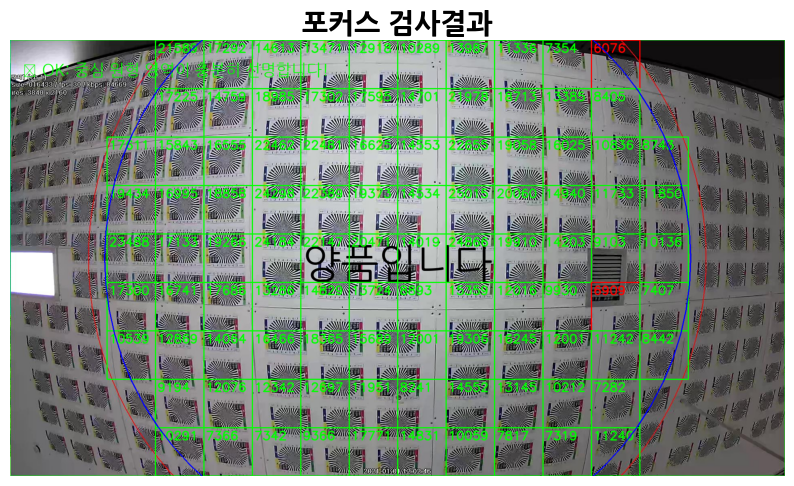

ValueError: The number of classes has to be greater than one; got 1 class

In [14]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from PIL import ImageFont, ImageDraw, Image
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import os

def get_korean_font_path():
    # Jupyter 환경에서 사용할 수 있는 대표적인 한글 폰트 경로
    candidates = [
        "/usr/share/fonts/NanumFont/NanumGothic.ttf",
        "/usr/share/fonts/NanumFont/NanumGothicBold.ttf",
        "/usr/share/fonts/truetype/unfonts-core/UnDotum.ttf",
        "/usr/share/fonts/opentype/noto/NotoSansCJK-Regular.ttc"
    ]
    for path in candidates:
        if os.path.exists(path):
            return path
    return None  # 폰트가 없을 경우

# ---- 전역 Matplotlib 폰트 설정 ----
font_path = get_korean_font_path()
if font_path:
    plt.rcParams['font.family'] = fm.FontProperties(fname=font_path).get_name()
    plt.rcParams['axes.unicode_minus'] = False
else:
    print("⚠️ 한글 폰트를 찾을 수 없습니다. Matplotlib 제목은 깨질 수 있습니다.")

def analyze_blur_grid(image_path, grid_x=5, grid_y=4, threshold=10000.0):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        raise ValueError("이미지를 불러올 수 없습니다.")

    height, width = image.shape
    seg_w = width // grid_x
    seg_h = height // grid_y

    print(f"이미지 크기: {width}x{height}")
    print(f"{grid_x}x{grid_y} 격자로 나눠 분석합니다.\n")

    cx = width // 2
    cy = height // 2
    radius = int(np.sqrt(0.8 * width * height / np.pi))

    sharp_count = 0
    central_segment_count = 0
    scores = {}

    for i in range(grid_y):
        for j in range(grid_x):
            y_start = i * seg_h
            y_end = (i + 1) * seg_h if i < grid_y - 1 else height
            x_start = j * seg_w
            x_end = (j + 1) * seg_w if j < grid_x - 1 else width

            center_x = (x_start + x_end) // 2
            center_y = (y_start + y_end) // 2
            distance = np.sqrt((center_x - cx)**2 + (center_y - cy)**2)

            if distance <= radius:
                segment = image[y_start:y_end, x_start:x_end]
                laplacian = cv2.Laplacian(segment, cv2.CV_64F)
                variance = laplacian.var()
                scores[(i, j)] = (variance, (x_start, y_start, x_end, y_end))
                status = "OK" if variance >= threshold else "NG"
                if variance >= threshold:
                    sharp_count += 1
                central_segment_count += 1
                print(f"원형 구간 ({i+1},{j+1}): 분산 = {variance:.2f} → {status}")
            else:
                print(f"외곽 구간 ({i+1},{j+1}): 평가 제외")

    # ---- 항상 결과 출력 ----
    if central_segment_count == 0:
        print("⚠️ 원형 영역에 해당하는 구간이 없습니다.")
        sharp_ratio = 0
        message = "⚠️ 원형 영역 없음"
    else:
        sharp_ratio = sharp_count / central_segment_count
        print(f"\n원형 영역 선명 구간 비율: {sharp_ratio:.2%}")
        message = "✅ OK: 중심 원형 영역이 충분히 선명합니다!" if sharp_ratio >= 0.8 else "⚠️ 흐림: 중심 영역 선명도 부족"

    show_result_with_grid_scores(image_path, message, scores, threshold, cx, cy, radius, sharp_ratio)
    return scores, threshold

def show_result_with_grid_scores(image_path, message, scores, threshold, cx, cy, radius, sharp_ratio):
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError("이미지를 불러올 수 없습니다.")

    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_pil = Image.fromarray(img_rgb)
    draw = ImageDraw.Draw(img_pil)

    font_path = get_korean_font_path()
    if font_path:
        font = ImageFont.truetype(font_path, 40)
        msg_color = (0, 255, 0) if sharp_ratio >= 0.8 else (255, 0, 0)
        draw.text((30, 50), message, font=font, fill=msg_color)

        # ---- 추가: 양품 표시 (textbbox 사용) ----
        if sharp_ratio >= 0.95:
            center_x = img_pil.width // 2
            center_y = img_pil.height // 2
            font_big = ImageFont.truetype(font_path, 100)  # 크게 표시
            text = "양품입니다"
            bbox = draw.textbbox((0, 0), text, font=font_big)
            text_w = bbox[2] - bbox[0]
            text_h = bbox[3] - bbox[1]
            draw.text((center_x - text_w//2, center_y - text_h//2),
                      text, font=font_big, fill=(0, 0, 0))
    else:
        print("⚠️ 한글 폰트를 찾을 수 없습니다. 메시지를 출력하지 않습니다.")

    img = cv2.cvtColor(np.array(img_pil), cv2.COLOR_RGB2BGR)
    font_cv = cv2.FONT_HERSHEY_SIMPLEX

    for (i, j), (variance, (x_start, y_start, x_end, y_end)) in scores.items():
        color = (0, 255, 0) if variance >= threshold else (0, 0, 255)
        label = f"{variance:.0f}"
        cv2.rectangle(img, (x_start, y_start), (x_end, y_end), color, 2)
        text_x = x_start + 5
        text_y = y_start + 30
        cv2.putText(img, label, (text_x, text_y), font_cv, 1.0, color, 2, cv2.LINE_AA)

    cv2.circle(img, (cx, cy), radius, (255, 0, 0), 2)

    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(10, 8))
    plt.imshow(img_rgb)
    plt.title("포커스 검사결과", fontsize=20, fontweight='bold')
    plt.axis("off")
    plt.show()

# 실행 및 머신러닝 평가
scores, threshold = analyze_blur_grid("FOCUS2.jpg", grid_x=16, grid_y=9, threshold=7000.0)

X = []
y = []

for (i, j), (variance, _) in scores.items():
    X.append([variance])
    y.append(1 if variance >= threshold else 0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
model = SVC()
model.fit(X_train, y_train)
pred = model.predict(X_test)
print("정확도:", accuracy_score(y_test, pred))



외곽 구간 (1,1): 평가 제외
외곽 구간 (1,2): 평가 제외
외곽 구간 (1,3): 평가 제외
원형 구간 (1,4): 분산=21589.15 → OK
원형 구간 (1,5): 분산=17291.53 → OK
원형 구간 (1,6): 분산=14612.65 → OK
원형 구간 (1,7): 분산=13471.22 → OK
원형 구간 (1,8): 분산=12917.54 → OK
원형 구간 (1,9): 분산=10289.26 → OK
원형 구간 (1,10): 분산=13986.80 → OK
원형 구간 (1,11): 분산=11335.81 → OK
원형 구간 (1,12): 분산=7353.76 → OK
원형 구간 (1,13): 분산=6075.57 → NG
외곽 구간 (1,14): 평가 제외
외곽 구간 (1,15): 평가 제외
외곽 구간 (1,16): 평가 제외
외곽 구간 (2,1): 평가 제외
외곽 구간 (2,2): 평가 제외
외곽 구간 (2,3): 평가 제외
원형 구간 (2,4): 분산=17224.74 → OK
원형 구간 (2,5): 분산=14758.80 → OK
원형 구간 (2,6): 분산=18985.24 → OK
원형 구간 (2,7): 분산=17302.11 → OK
원형 구간 (2,8): 분산=17595.20 → OK
원형 구간 (2,9): 분산=14700.79 → OK
원형 구간 (2,10): 분산=21977.63 → OK
원형 구간 (2,11): 분산=18712.82 → OK
원형 구간 (2,12): 분산=13384.91 → OK
원형 구간 (2,13): 분산=8404.84 → OK
외곽 구간 (2,14): 평가 제외
외곽 구간 (2,15): 평가 제외
외곽 구간 (2,16): 평가 제외
외곽 구간 (3,1): 평가 제외
외곽 구간 (3,2): 평가 제외
원형 구간 (3,3): 분산=17611.28 → OK
원형 구간 (3,4): 분산=15842.71 → OK
원형 구간 (3,5): 분산=16555.17 → OK
원형 구간 (3,6): 분산=22461.56 → OK
원형 

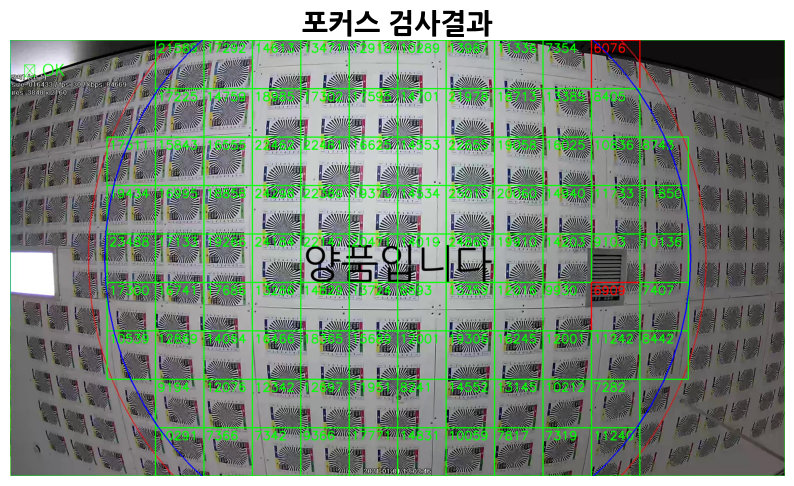

정확도: 1.0
좌상 분산=17277.98
우상 분산=11904.93
좌하 분산=11662.32
우하 분산=10617.43

좌우 편심: 왼쪽=14470.15, 오른쪽=11261.18
상하 편심: 위쪽=14591.45, 아래쪽=11139.88
➡️ 왼쪽이 편심입니다.
⬆️ 위쪽이 편심입니다.


In [16]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from PIL import ImageFont, ImageDraw, Image
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import os

# ---- 공통 유틸 함수 ----
def get_korean_font_path():
    candidates = [
        "/usr/share/fonts/NanumFont/NanumGothic.ttf",
        "/usr/share/fonts/NanumFont/NanumGothicBold.ttf",
        "/usr/share/fonts/truetype/unfonts-core/UnDotum.ttf",
        "/usr/share/fonts/opentype/noto/NotoSansCJK-Regular.ttc"
    ]
    for path in candidates:
        if os.path.exists(path):
            return path
    return None

def calc_variance(segment):
    return cv2.Laplacian(segment, cv2.CV_64F).var()

def draw_center_text(draw, text, font_path, size, img_w, img_h, color=(0,0,0)):
    font_big = ImageFont.truetype(font_path, size)
    bbox = draw.textbbox((0, 0), text, font=font_big)
    text_w = bbox[2] - bbox[0]
    text_h = bbox[3] - bbox[1]
    draw.text(((img_w - text_w)//2, (img_h - text_h)//2), text, font=font_big, fill=color)

# ---- 전역 Matplotlib 폰트 설정 ----
font_path = get_korean_font_path()
if font_path:
    plt.rcParams['font.family'] = fm.FontProperties(fname=font_path).get_name()
    plt.rcParams['axes.unicode_minus'] = False

# ---- 블러 분석 ----
def analyze_blur_grid(image_path, grid_x=5, grid_y=4, threshold=10000.0):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        raise ValueError("이미지를 불러올 수 없습니다.")

    h, w = image.shape
    seg_w, seg_h = w // grid_x, h // grid_y
    cx, cy = w // 2, h // 2
    radius = int(np.sqrt(0.8 * w * h / np.pi))

    sharp_count, central_count = 0, 0
    scores = {}

    for i in range(grid_y):
        for j in range(grid_x):
            y0, y1 = i * seg_h, (i + 1) * seg_h if i < grid_y - 1 else h
            x0, x1 = j * seg_w, (j + 1) * seg_w if j < grid_x - 1 else w
            cx_seg, cy_seg = (x0 + x1)//2, (y0 + y1)//2
            dist = np.sqrt((cx_seg - cx)**2 + (cy_seg - cy)**2)

            if dist <= radius:
                var = calc_variance(image[y0:y1, x0:x1])
                scores[(i, j)] = (var, (x0, y0, x1, y1))
                status = "OK" if var >= threshold else "NG"
                if var >= threshold: sharp_count += 1
                central_count += 1
                print(f"원형 구간 ({i+1},{j+1}): 분산={var:.2f} → {status}")
            else:
                print(f"외곽 구간 ({i+1},{j+1}): 평가 제외")

    sharp_ratio = sharp_count / central_count if central_count else 0
    print(f"\n원형 영역 선명 구간 비율: {sharp_ratio:.2%}" if central_count else "⚠️ 원형 영역 없음")
    message = "✅ OK" if sharp_ratio >= 0.8 else "⚠️ 흐림"
    show_result_with_grid_scores(image_path, message, scores, threshold, cx, cy, radius, sharp_ratio)
    return scores, threshold

# ---- 결과 시각화 ----
def show_result_with_grid_scores(image_path, message, scores, threshold, cx, cy, radius, sharp_ratio):
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_pil = Image.fromarray(img_rgb)
    draw = ImageDraw.Draw(img_pil)

    if font_path:
        font = ImageFont.truetype(font_path, 40)
        msg_color = (0,255,0) if sharp_ratio >= 0.8 else (255,0,0)
        draw.text((30,50), message, font=font, fill=msg_color)
        if sharp_ratio >= 0.95:
            draw_center_text(draw, "양품입니다", font_path, 100, img_pil.width, img_pil.height, color=(0,0,0))

    img = cv2.cvtColor(np.array(img_pil), cv2.COLOR_RGB2BGR)
    for (i,j),(var,(x0,y0,x1,y1)) in scores.items():
        color = (0,255,0) if var >= threshold else (0,0,255)
        cv2.rectangle(img,(x0,y0),(x1,y1),color,2)
        cv2.putText(img,f"{var:.0f}",(x0+5,y0+30),cv2.FONT_HERSHEY_SIMPLEX,1.0,color,2)

    cv2.circle(img,(cx,cy),radius,(255,0,0),2)
    plt.figure(figsize=(10,8))
    plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
    plt.title("포커스 검사결과",fontsize=20,fontweight='bold')
    plt.axis("off")
    plt.show()

# ---- 사분할 편심 분석 ----
def analyze_quadrant_bias(image_path, threshold=10000.0):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    h,w = image.shape
    mid_h, mid_w = h//2, w//2
    quadrants = {
        "좌상": image[0:mid_h,0:mid_w],
        "우상": image[0:mid_h,mid_w:w],
        "좌하": image[mid_h:h,0:mid_w],
        "우하": image[mid_h:h,mid_w:w],
    }
    results = {name: calc_variance(seg) for name,seg in quadrants.items()}
    for k,v in results.items(): print(f"{k} 분산={v:.2f}")

    left_mean = (results["좌상"]+results["좌하"])/2
    right_mean = (results["우상"]+results["우하"])/2
    top_mean = (results["좌상"]+results["우상"])/2
    bottom_mean = (results["좌하"]+results["우하"])/2

    print(f"\n좌우 편심: 왼쪽={left_mean:.2f}, 오른쪽={right_mean:.2f}")
    print(f"상하 편심: 위쪽={top_mean:.2f}, 아래쪽={bottom_mean:.2f}")

    if abs(left_mean-right_mean)>=1000:
        print("➡️ 왼쪽이 편심입니다." if left_mean>right_mean else "➡️ 오른쪽이 편심입니다.")
    else: print("좌우 편심 없음")

    if abs(top_mean-bottom_mean)>=1000:
        print("⬆️ 위쪽이 편심입니다." if top_mean>bottom_mean else "⬇️ 아래쪽이 편심입니다.")
    else: print("상하 편심 없음")

    return results

# ---- 실행 ----
scores, threshold = analyze_blur_grid("FOCUS2.jpg", grid_x=16, grid_y=9, threshold=7000.0)
X,y = [],[]
for (i,j),(var,_) in scores.items():
    X.append([var]); y.append(1 if var>=threshold else 0)

if len(set(y))>1:
    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)
    model=SVC(); model.fit(X_train,y_train)
    pred=model.predict(X_test)
    print("정확도:",accuracy_score(y_test,pred))
else:
    print("⚠️ 클래스가 하나뿐이라 SVM 학습을 건너뜁니다.")

quadrant_scores = analyze_quadrant_bias("FOCUS2.jpg")